# Feature Extraction and Fine Tuning using Tensorflow

In [ ]:
import tensorflow as tf
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import zipfile
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2024-04-12 11:54:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 142.250.145.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.2MB/s    in 4.6s    

2024-04-12 11:54:56 (34.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Data Preprocessing

> Saving train and test locations as train_dir and test_dir

In [ ]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

>Extracting files as data for model using tensorflow `image_dataset_from_directory` function

In [ ]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size=32,
                                                                 label_mode='categorical',
                                                                 image_size=(224,224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               batch_size=32,
                                                               label_mode='categorical',
                                                               image_size=(224,224))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


> Create Augmented layer for input images. This layer is a type of `Sequentail` model from `keras`

In [ ]:
from tensorflow.keras import layers

data_augmented = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
],name='Augmented_layer')

## Feature Extraction Model Building

> Functional Model using EfficientNetB0 model already prepared with layers

In [ ]:
# from tensorflow.keras.engine.Sequential import training
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name='Input_layer')

x = data_augmented(inputs)

x = base_model(x,training=False)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(10,activation='softmax')(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')

16705208/16705208 [==============================] - 1s 0us/step


> Creating a checkpoint for using the same model with weights it trained with

In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',save_weights_only=True,save_best_only=True,save_freq='epoch')

> Training model and save history in history_1 and saving ModelCheckpoint callback

In [ ]:
initial_epochs = 5

history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 1.9544 - accuracy: 0.3560 - val_loss: 1.4357 - val_accuracy: 0.6941
Epoch 2/5
24/24 [==============================] - 21s 887ms/step - loss: 1.2879 - accuracy: 0.7027 - val_loss: 0.9943 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 18s 733ms/step - loss: 0.9850 - accuracy: 0.7813 - val_loss: 0.7830 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 18s 734ms/step - loss: 0.8148 - accuracy: 0.7987 - val_loss: 0.6670 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 16s 612ms/step - loss: 0.7210 - accuracy: 0.8360 - val_loss: 0.6106 - val_accuracy: 0.8339


In [ ]:
feature_results = model_1.evaluate(test_data)

79/79 [==============================] - 7s 87ms/step - loss: 0.6205 - accuracy: 0.8428


In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


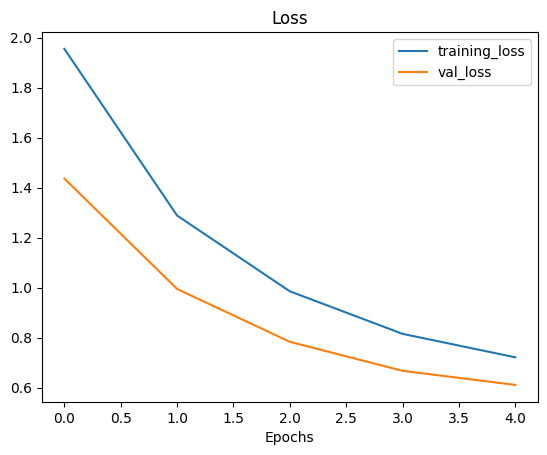

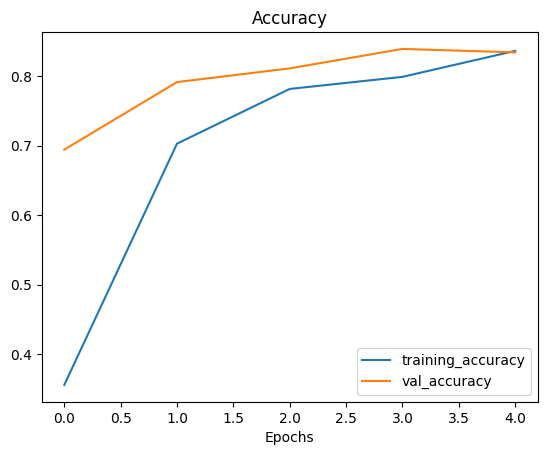

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.layers

In [ ]:
for layer in model_1.layers:
  print(layer.trainable)

True
True
False
True
True


> Checking Number of layers in base_model and which are trainable

In [ ]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Augmented_layer (Sequentia  (None, None, None, 3)     0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                             

## Finetune Model Building

> Setting last ten 10 only for training and remaining non trainable

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

> Fitting model and save in history_2

In [ ]:
history_2 = model_1.fit(train_data,
                        epochs=initial_epochs+5,
                        initial_epoch=history_1.epoch[-1],
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        steps_per_epoch=len(train_data))

Epoch 5/10
24/24 [==============================] - 30s 828ms/step - loss: 0.6327 - accuracy: 0.8280 - val_loss: 0.4675 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 13s 537ms/step - loss: 0.5191 - accuracy: 0.8373 - val_loss: 0.4555 - val_accuracy: 0.8388
Epoch 7/10
24/24 [==============================] - 15s 594ms/step - loss: 0.4430 - accuracy: 0.8853 - val_loss: 0.4480 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 13s 546ms/step - loss: 0.3992 - accuracy: 0.8920 - val_loss: 0.4329 - val_accuracy: 0.8553
Epoch 9/10
24/24 [==============================] - 13s 537ms/step - loss: 0.3752 - accuracy: 0.8947 - val_loss: 0.4408 - val_accuracy: 0.8438
Epoch 10/10
24/24 [==============================] - 12s 482ms/step - loss: 0.3257 - accuracy: 0.9053 - val_loss: 0.4333 - val_accuracy: 0.8503


In [ ]:
fine_tune_results = model_1.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4401 - accuracy: 0.8572


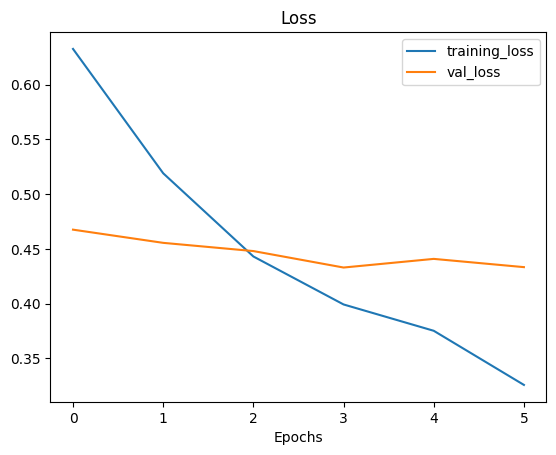

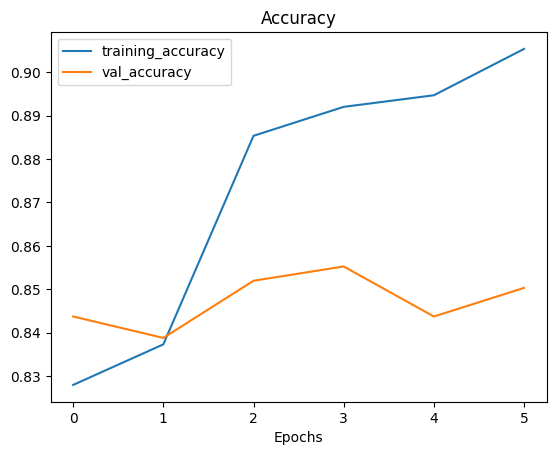

In [ ]:
plot_loss_curves(history_2)

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):

    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

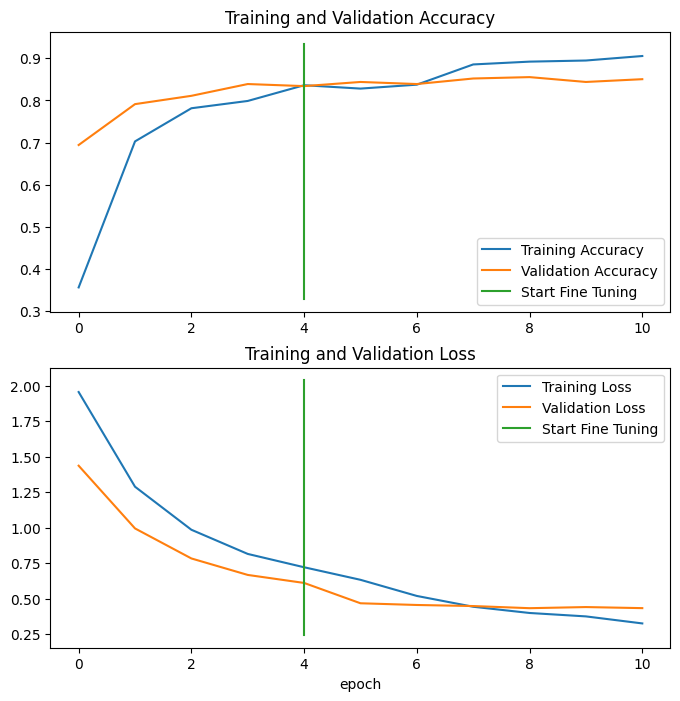

In [ ]:
compare_historys(original_history=history_1,
                 new_history=history_2)

## Evaluating Model

In [ ]:
class_names = train_data.class_names

> Plot a random single image with prediction

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)

  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:

    return img/255.
  else:
    return img

1/1 [==============================] - 0s 28ms/step


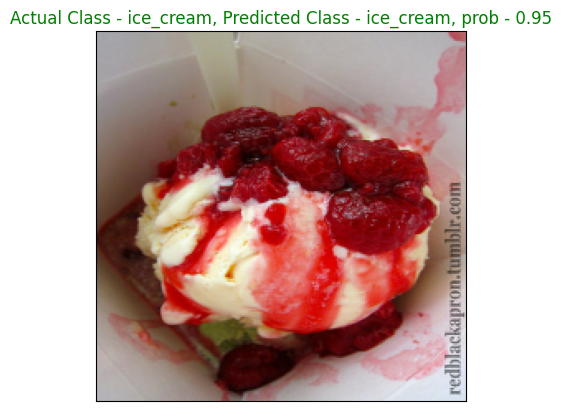

In [ ]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class_name = random.choice(class_names)
filename = random.choice(os.listdir(test_dir + '/' + class_name))
filepath = test_dir + '/' + class_name + '/' + filename
img = load_and_prep_image(filepath,scale=False)
pred_prob = model_1.predict(tf.expand_dims(img,axis=0))
pred_class = class_names[pred_prob.argmax()]
plt.figure()
fig = plt.imshow(img/255.)
if pred_class==class_name:
  color='g'
else:
  color='r'
plt.title(f"Actual Class - {class_name}, Predicted Class - {pred_class}, prob - {pred_prob.max():.2f}",c=color)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

> Plotting 9 random images with prediction

1/1 [==============================] - 0s 27ms/step


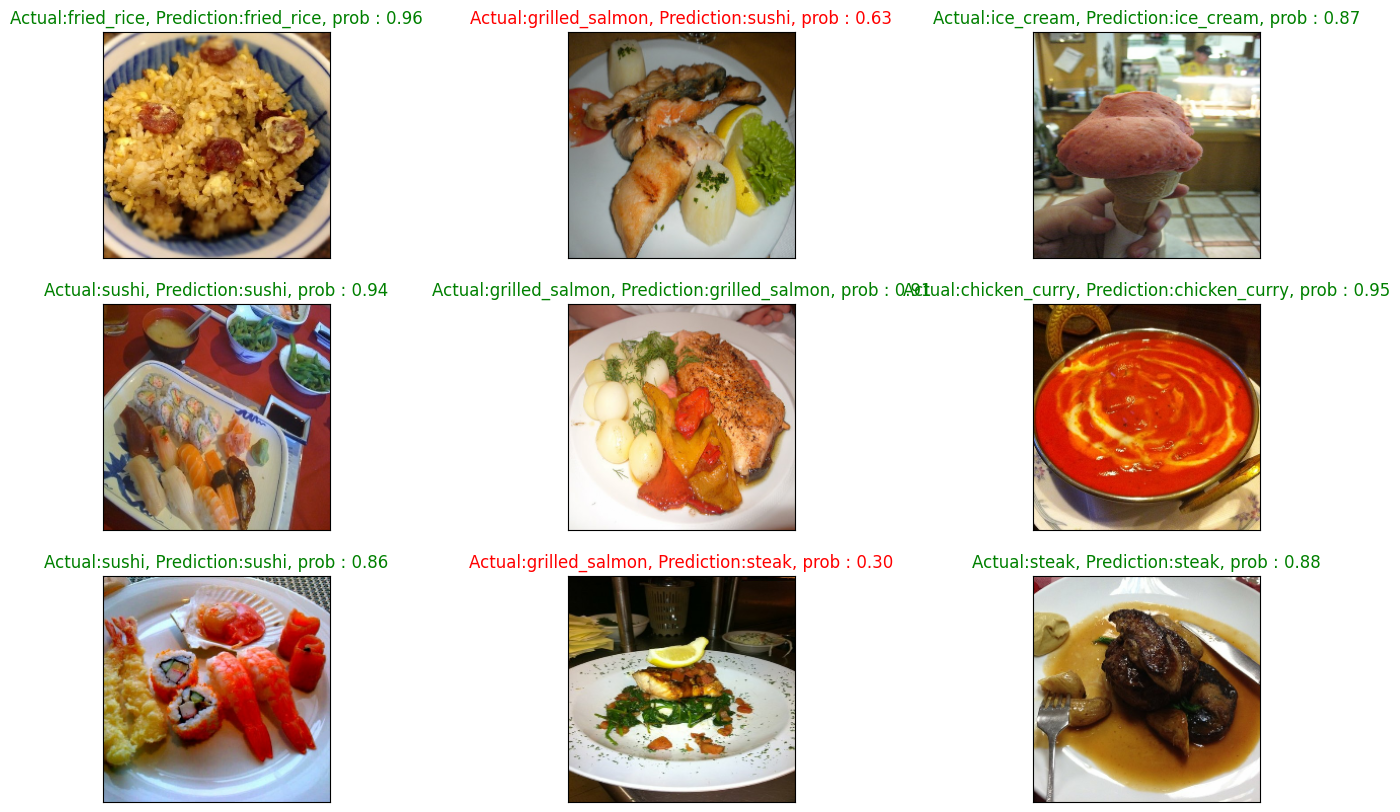

In [ ]:
plt.figure(figsize=(17, 10))
for i in range(9):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + '/' + class_name + '/' + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(3, 3, i+1)
  fig = plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual:{class_name}, Prediction:{pred_class}, prob : {pred_prob.max():.2f}", c=title_color)
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)


> Creating Non shuffled data for confusion Matrix

In [ ]:
test_data_not_shuffled = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                             label_mode='categorical',
                                                                             batch_size=32,
                                                                             shuffle=False, # Non Shuffled Data for confusion matrix
                                                                             image_size=(224,224))

Found 2500 files belonging to 10 classes.


In [ ]:
model_1.evaluate(test_data_not_shuffled)

79/79 [==============================] - 7s 90ms/step - loss: 0.4401 - accuracy: 0.8572


[0.4401381313800812, 0.857200026512146]

In [ ]:
pred_probs = model_1.predict(test_data_not_shuffled)

79/79 [==============================] - 7s 69ms/step


In [ ]:
len(pred_probs)

2500

In [ ]:
pred_probs.shape

(2500, 10)

> True Test Labels

In [ ]:
ylabels = []

for images, labels in test_data_not_shuffled.unbatch():
  ylabels.append(labels.numpy().argmax())

ylabels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pred_probs[:10]

array([[9.49067473e-01, 1.92481923e-04, 5.62649802e-04, 9.05897934e-04,
        1.25756105e-05, 3.54964550e-06, 1.12129837e-05, 4.50929217e-02,
        4.08257730e-03, 6.86459462e-05],
       [8.46981168e-01, 1.90574117e-03, 2.14194460e-03, 1.89523341e-03,
        7.24966871e-04, 2.17419962e-04, 7.53245491e-04, 1.39603555e-01,
        5.34775015e-03, 4.28922853e-04],
       [7.87003696e-01, 7.07452651e-04, 1.21695695e-04, 1.94840264e-04,
        1.53021159e-04, 5.42232156e-05, 6.98649734e-02, 1.39451757e-01,
        2.36766273e-03, 8.06334065e-05],
       [8.18161786e-01, 1.09174512e-02, 2.69622225e-02, 1.82735715e-02,
        3.83077771e-03, 1.15194140e-04, 3.53630469e-03, 1.10100709e-01,
        7.46694161e-03, 6.34964264e-04],
       [4.96757209e-01, 1.23916368e-03, 2.87450552e-01, 1.51411384e-01,
        7.94760324e-03, 1.58507540e-03, 1.99457593e-02, 2.23249029e-02,
        6.28153980e-03, 5.05686551e-03],
       [9.93813157e-01, 2.38759412e-06, 2.77609710e-04, 1.49524596e-04,
   

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(ylabels, pred_classes)
sklearn_accuracy

0.8572

Plotting Confusion Matrix

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")

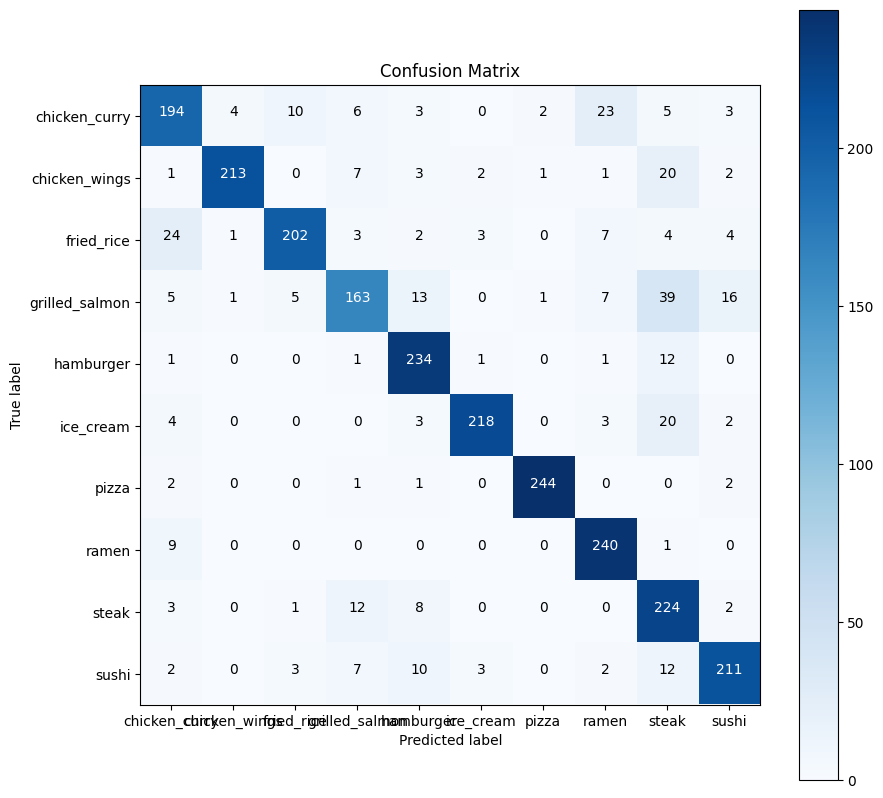

In [ ]:
make_confusion_matrix(y_true=ylabels,y_pred=pred_classes,classes=class_names,text_size=10)

1/1 [==============================] - 0s 42ms/step


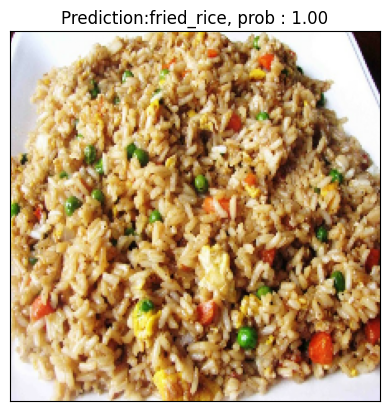

In [ ]:
img=load_and_prep_image("/content/friedrice.jpg",scale=False)
pred_prob = model_1.predict(tf.expand_dims(img, axis=0))
pred_class = class_names[pred_prob.argmax()]
fig = plt.imshow(img/255.)
plt.title(f"Prediction:{pred_class}, prob : {pred_prob.max():.2f}")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

1/1 [==============================] - 0s 55ms/step


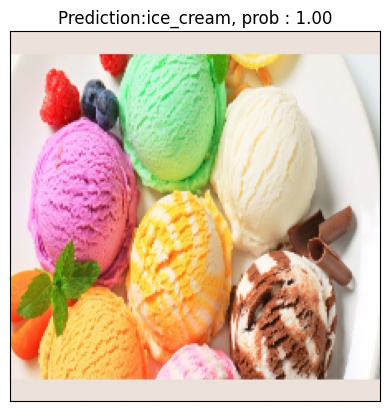

In [ ]:
img=load_and_prep_image("/content/icecream.jpg",scale=False)
pred_prob = model_1.predict(tf.expand_dims(img, axis=0))
pred_class = class_names[pred_prob.argmax()]
fig = plt.imshow(img/255.)
plt.title(f"Prediction:{pred_class}, prob : {pred_prob.max():.2f}")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)